In [ ]:
import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np

def edge_correlation_experiment(img_path, downsample_factor=4, noise_size=256, top_k=10, dilation_iterations=10, device="cuda"):
    # 1. Load image and convert to grayscale tensor
    img = Image.open(img_path).convert('L')
    img = np.asarray(img)
    img_tensor = torch.tensor(img, dtype=torch.float32, device=device).reshape(1, 1, *img.shape)  # (1,1,H,W)
    
    # 2. High-pass filter (edge detection)
    edge_kernel = torch.tensor([[-1,-1,-1], 
                               [-1, 8,-1],
                               [-1,-1,-1]], dtype=torch.float32, device=device).view(1,1,3,3)
    edges = F.conv2d(img_tensor, edge_kernel, padding=1)

    # 3. Binary dilation on edges via max-pool
    dilated = edges
    for _ in range(dilation_iterations):
        dilated = F.max_pool2d(dilated, kernel_size=3, stride=1, padding=1)

    # 4. Downsample dilated edges
    downsampled = F.interpolate(
        dilated,
        scale_factor=1/downsample_factor,
        mode='bilinear',
        align_corners=False
    )

    # 4. Generate noise grid and correlate
    noise = torch.randn(1, 1, noise_size, noise_size, device=device)
    correlation = F.conv2d(noise, downsampled.flip((-1,-2)), 
                          padding=downsampled.shape[-1]//2)

    # 5. Find top correlation points
    values, indices = torch.topk(correlation.view(-1), top_k)
    avg_correlation = values.mean().item()
    
    return indices, edges, downsampled, correlation, noise


corr_inds, edges, ds, corr, noise = edge_correlation_experiment("filter_base.png", top_k=2000, noise_size=10_000, device="cpu")
corr_inds_xy = torch.unravel_index(corr_inds, corr.squeeze().shape)


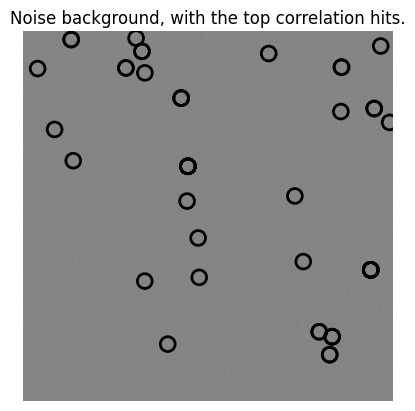

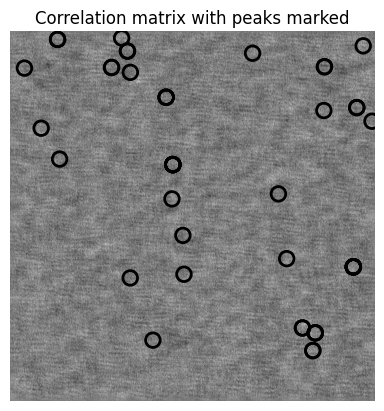

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def draw_circles(img, xs, ys, radius=100, title=None):
    fig, ax = plt.subplots()
    # show the image
    plt.imshow(img, cmap="gray")
    ax.set_aspect('equal')               # ensure circles aren’t warped
    
    edge_color = 'black'
    face_color = 'none'                  # transparent fill

    for x, y in zip(xs, ys):
        circ = Circle((x, y), radius,
                    edgecolor=edge_color,
                    facecolor=face_color,
                    linewidth=2)
        ax.add_patch(circ)               # draw each circle

    plt.axis('off')                      # hide axes if desired
    if title is not None:
        plt.title(title)
    plt.show()

# Example usage:
n_cicles = 50
draw_circles(img=noise.squeeze().cpu().numpy(), xs=corr_inds_xy[0][:n_cicles], ys=corr_inds_xy[1][:n_cicles], radius=200,
             title="Noise background, with the top correlation hits.")
draw_circles(img=corr.squeeze().cpu().numpy(), xs=corr_inds_xy[0][:n_cicles], ys=corr_inds_xy[1][:n_cicles], radius=200,
             title="Correlation matrix with peaks marked")

In [ ]:
def extract_patches_at_2d(img, centers, patch_size, pad_mode='constant', pad_val=0):
    """
    img:        2D tensor of shape (H, W)
    centers:    LongTensor of shape (N, 2), each = (row, col)
    patch_size: tuple (ph, pw)
    Returns:    FloatTensor of shape (N, ph, pw)
    """
    ph, pw = patch_size
    # compute symmetric padding
    pad_y = (ph - 1) // 2
    pad_x = (pw - 1) // 2

    # pad image
    img_p = F.pad(
        img.unsqueeze(0).unsqueeze(0),
        (pad_x, pad_x, pad_y, pad_y),
        mode=pad_mode, value=pad_val
    ).squeeze(0).squeeze(0)

    # build offset grid of exact size ph×pw
    # y offsets: [-pad_y, …, +pad_y] length ph
    y_offs = torch.arange(ph, device=img.device) - pad_y
    # x offsets: [-pad_x, …, +pad_x] length pw
    x_offs = torch.arange(pw, device=img.device) - pad_x
    # mesh to get all (dy, dx) pairs, then flatten to (ph*pw, 2)
    yy, xx = torch.meshgrid(y_offs, x_offs, indexing='ij')
    offsets = torch.stack((yy.flatten(), xx.flatten()), dim=-1)  # (ph*pw, 2)

    # shift centers into padded coords
    centers_p = centers.to(img.device) + torch.tensor([pad_y, pad_x], device=img.device)

    # compute all sample coordinates: (N, ph*pw, 2)
    coords = centers_p.unsqueeze(1) + offsets.unsqueeze(0)

    # gather values
    rows = coords[..., 0].flatten()
    cols = coords[..., 1].flatten()
    vals = img_p[rows, cols]                            # (N*ph*pw,)
    patches = vals.view(-1, ph, pw)                     # (N, ph, pw)
    return patches


In [ ]:
corr_inds_x = corr_inds_xy[0].clone()
corr_inds_y = corr_inds_xy[1].clone()
centers = torch.stack([corr_inds_x-65, corr_inds_y]).T
# no idea where the error is so monkeypatching

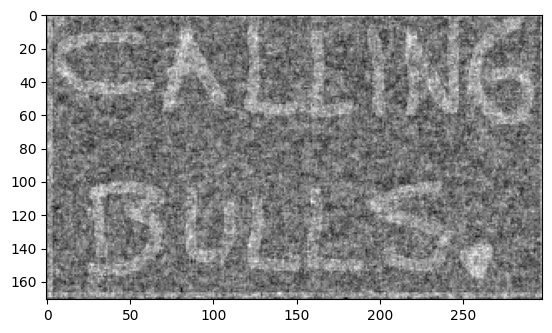

In [ ]:
patches = extract_patches_at_2d(noise.squeeze(), centers, ds.squeeze().shape)
plt.imshow(torch.flip(patches.mean(dim=0), dims=(0,1)).cpu().numpy(), cmap="gray")

In [ ]:
from PIL import Image
import numpy as np

# Suppose imgs has shape (N, H, W, 3), dtype=uint8
imgs = torch.flip(patches, dims=(1,2))
imgs = (imgs - imgs.min())/(imgs.max() - imgs.min()) * 255
imgs = imgs.to(dtype=torch.uint8).cpu().numpy()[::10]

# Convert each frame to a PIL Image
frames = [Image.fromarray(frame) for frame in imgs]

duration_in_seconds = 5
# Save as animated GIF
frames[0].save(
    'assets/individual_frames.gif',
    format='GIF',
    save_all=True,
    append_images=frames[1:],
    duration=duration_in_seconds/len(frames),   # milliseconds per frame
    loop=0          # 0 = infinite loop
)

In [ ]:
def cumulative_average(tensor):
    """
    Computes cumulative average along dim=0 for tensor of shape (N, W, H)
    
    Args:
        tensor: Input tensor (N, W, H)
        
    Returns:
        Tensor of same shape where each element [k] = mean(tensor[0:k+1])
    """
    cumsum = torch.cumsum(tensor, dim=0)  # Shape (N, W, H)
    divisor = torch.arange(1, tensor.size(0)+1, device=tensor.device, 
                          dtype=torch.float32).view(-1, 1, 1)
    return cumsum / divisor

imgs_cum_avg_t = cumulative_average(torch.flip(patches, dims=(1,2)))

In [ ]:
per_frame_vector = imgs_cum_avg_t.view(imgs_cum_avg_t.size(0), -1)
imgs_cum_avg = (imgs_cum_avg_t - per_frame_vector.min(dim=1).values.view(-1, 1, 1))/(per_frame_vector.max(dim=1).values.view(-1, 1, 1) - per_frame_vector.min(dim=1).values.view(-1, 1, 1))*255
imgs_cum_avg = imgs_cum_avg.to(torch.uint8).cpu().numpy()

# Convert each frame to a PIL Image
frames = [Image.fromarray(frame) for frame in imgs_cum_avg[::10]]

duration_in_seconds = 5
# Save as animated GIF
frames[0].save(
    'assets/cumulative_average.gif',
    format='GIF',
    save_all=True,
    append_images=frames[1:],
    duration=duration_in_seconds/len(frames),   # milliseconds per frame
    loop=2,        # 0 = infinite loop
)
